In [1]:
import pandas as pd  
import numpy as np
import sys,glob,os,time
import vaex
import pylab as plt
import seaborn as sea 
import math

import matplotlib as mpl
import matplotlib.cm as cm

import matplotlib.colors as colors
import matplotlib.ticker as mtick
from matplotlib.patches import Circle


import matplotlib.patheffects as path_effects

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


sea.set(font_scale=3,palette=sea.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'})
sea.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


pi = math.pi
%config IPCompleter.use_jedi = False ### IN CASE TAB-AUTO COMPLETE IS SLOW!!!

In [2]:
labels = dict(
    G_RP = 'G - G$_\mathrm{RP}$',
    G_BP = 'G - G$_\mathrm{BP}$',
    BP_RP = 'G$_\mathrm{BP}$ - G$_\mathrm{RP}$',
    Gabs = 'G$_\mathrm{abs}$')


In [3]:
# Opening isochrone
iso = pd.read_table('./isochrones/Mh-1.3_Age13Gyr.dat',
                     comment='#',delim_whitespace=True)

# G,BP,RP,label = iso[['Gmag','G_BPmag','G_RPmag','label']].values.T

iso['G_RP'] = iso['Gmag'] - iso['G_RPmag']
iso['BP_RP'] = iso['G_BPmag'] - iso['G_RPmag']

In [4]:
data_x = np.random.uniform(low=1,high=1.5,size=1000)
data_y = np.random.uniform(low=-5,high=5,size=1000)

In [5]:
mask = (iso['label']==3)
x = iso['BP_RP'][mask]
y = iso['Gmag'][mask]
yy = y+2
s1 = data_y < np.interp(data_x, x,yy)
s2 = data_y > np.interp(data_x, x,y)

In [6]:
def apparent_magnitude(distance, Gabs=iso['Gmag']):
    return Gabs + 5 * np.log10(distance) + 10

In [7]:
def isochrone_mask(d_lower, d_upper, data_x, data_y):
    mask = (iso['label']==3)
    x = iso['BP_RP'][mask]
    y = iso['Gmag'][mask]
    
    yy = apparent_magnitude(d_upper, y)
    y  = apparent_magnitude(d_lower, y)
    
    s1 = data_y < np.interp(data_x, x,yy)
    s2 = data_y > np.interp(data_x, x,y)

    return (s1&s2)



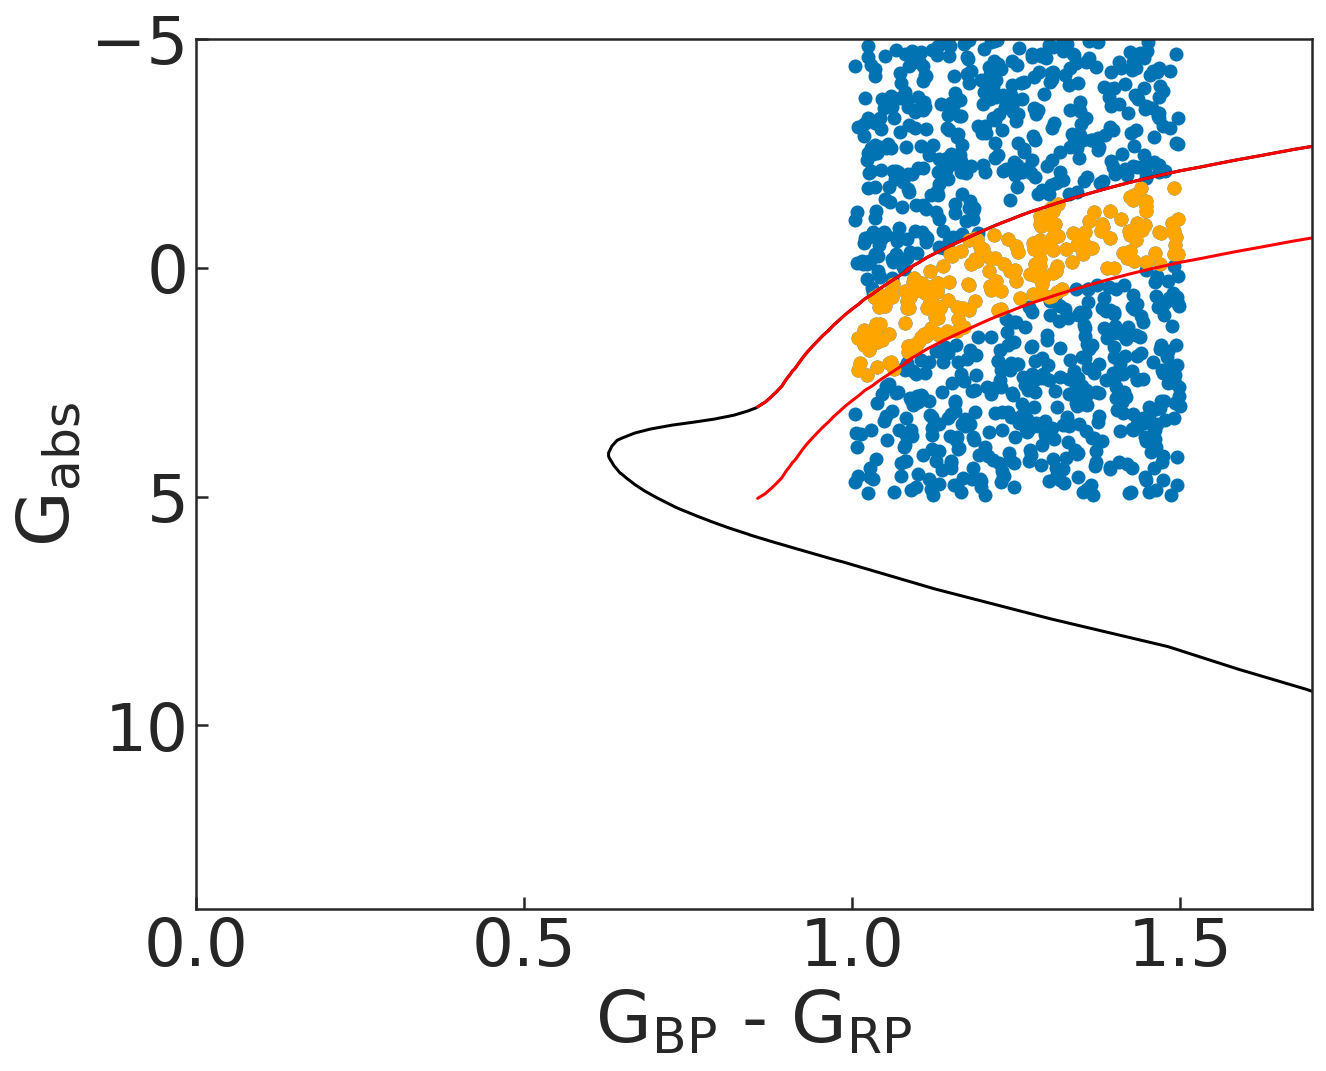

In [8]:
fig,ax = plt.subplots(ncols=1, figsize=(10,8),sharex=True,sharey=True)

mask = isochrone_mask(0.01, 0.02512 ,data_x,data_y)
plt.scatter(data_x,data_y)
# plt.scatter(data_x[s1&s2],data_y[s1&s2], c='orange')
plt.scatter(data_x[mask],data_y[mask], c='orange')



limits = [[0,1.7],[-5,14]]

plt.xlabel(labels['BP_RP'])
plt.ylabel(labels['Gabs'])

plt.xlim(*limits[0])
plt.ylim(*limits[1])
ax.invert_yaxis()



for _ax in [ax]:

    #isochrones
    mask = iso['label']<4
    _ax.plot(iso['BP_RP'][mask],iso['Gmag'][mask],c='k')
    
    mask = (iso['label']==3)
    _ax.plot(iso['BP_RP'][mask],iso['Gmag'][mask],c='r')

    mask = (iso['label']==3)
    _ax.plot(iso['BP_RP'][mask],iso['Gmag'][mask]+2,c='r')

- $G_\mathrm{abs} = m_g - 5\log_{10}{(d)} - 10$
- $H_g = m_g+5\log_{10}(\mu)-10$
- $H_g = G_\mathrm{abs} + 5\log_{10}(\frac{v_\mathrm{tan}}{4.74 (km s^{-1})})$


In [9]:
### Loading data
df = vaex.open('./Antlia2-lb-window-5deg.hdf5')
df['lc'] = df.l - 264.8955
df['bc'] = df.b - 11.2479

In [10]:
def angle_great_circle():
    lrad, brad =  df.lc.deg2rad(), df.bc.deg2rad()

    cosb = brad.cos()
    cosl = lrad.cos()
    
    df['angle'] = (cosb*cosl).arccos().rad2deg()



In [11]:
angle_great_circle()

$
    \cos(\alpha) = \cos(b)\cos(b_c)\cos(l-l_c) + \sin(b)\sin(b_c)
$

With $(l_c, b_c) = (0,0)$ this becomes

$
    \alpha = \arccos(\cos(b)\cos(l))
$

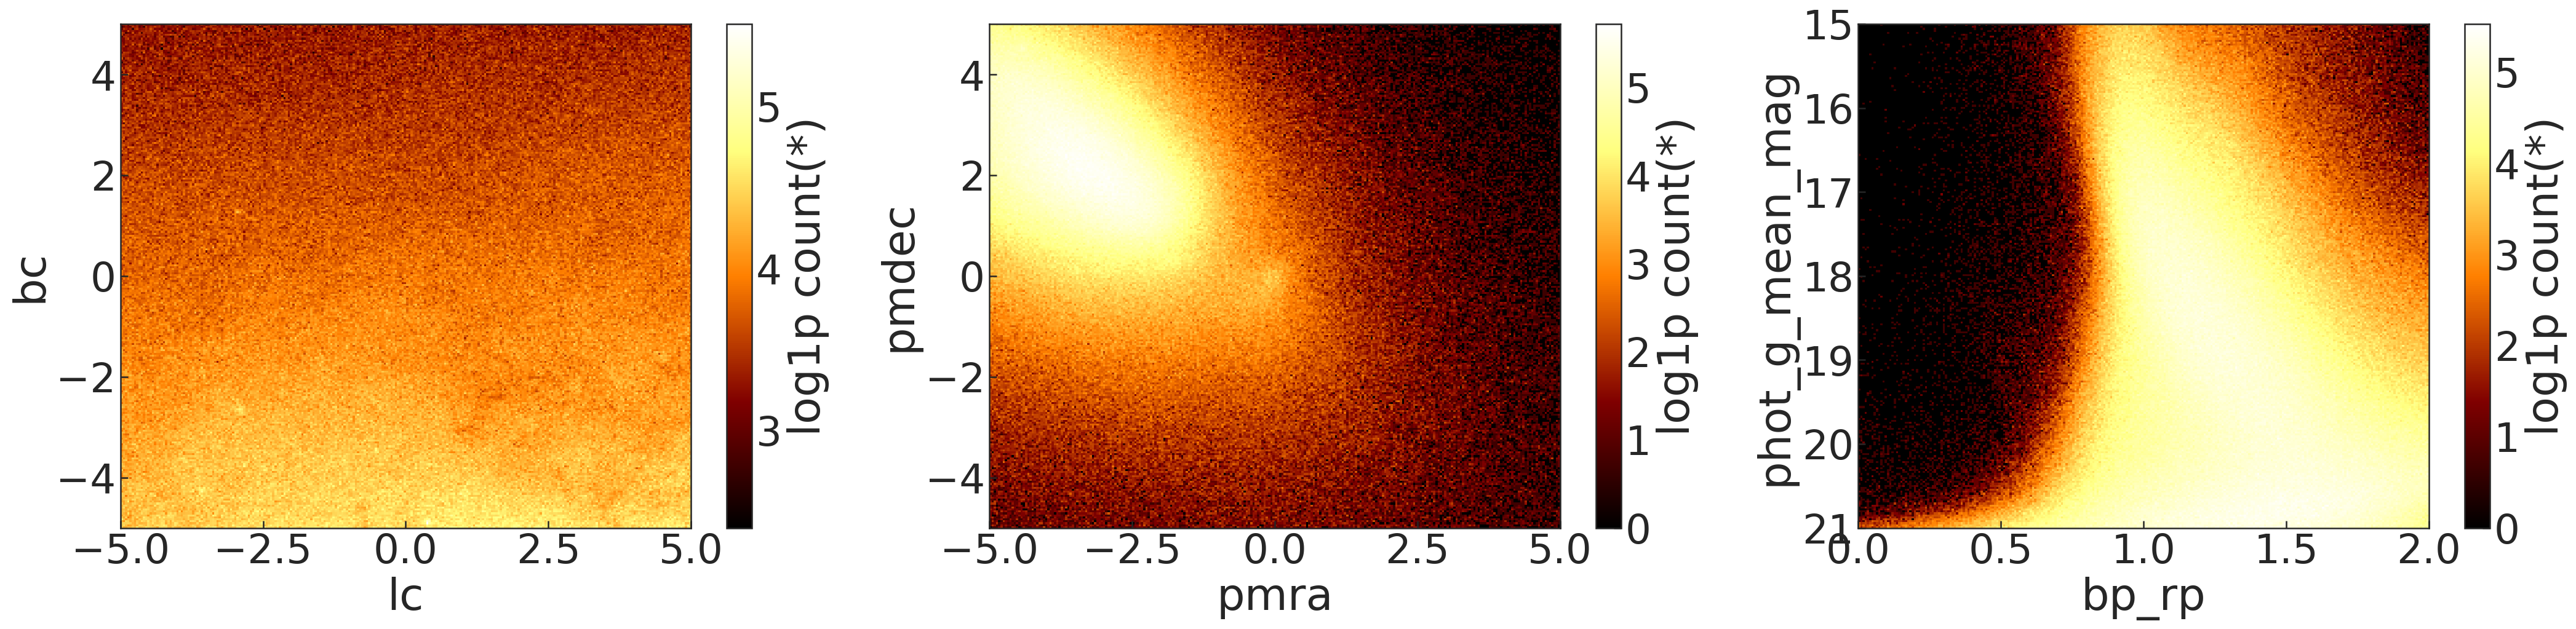

In [12]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection='ruwe<1.4')

plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection='ruwe<1.4')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p')

In [13]:
base_selection = (df.angle<2.5)&(df.parallax<0.25)&(df.ruwe<1.4)

We start by selecting all Gaia sources within $2^\circ.5$ of the center of Antlia 2 with parallax $\pi\lt 0.25$ mas.

In [14]:
df.count(selection=['',base_selection])

array([3848261,  227221])

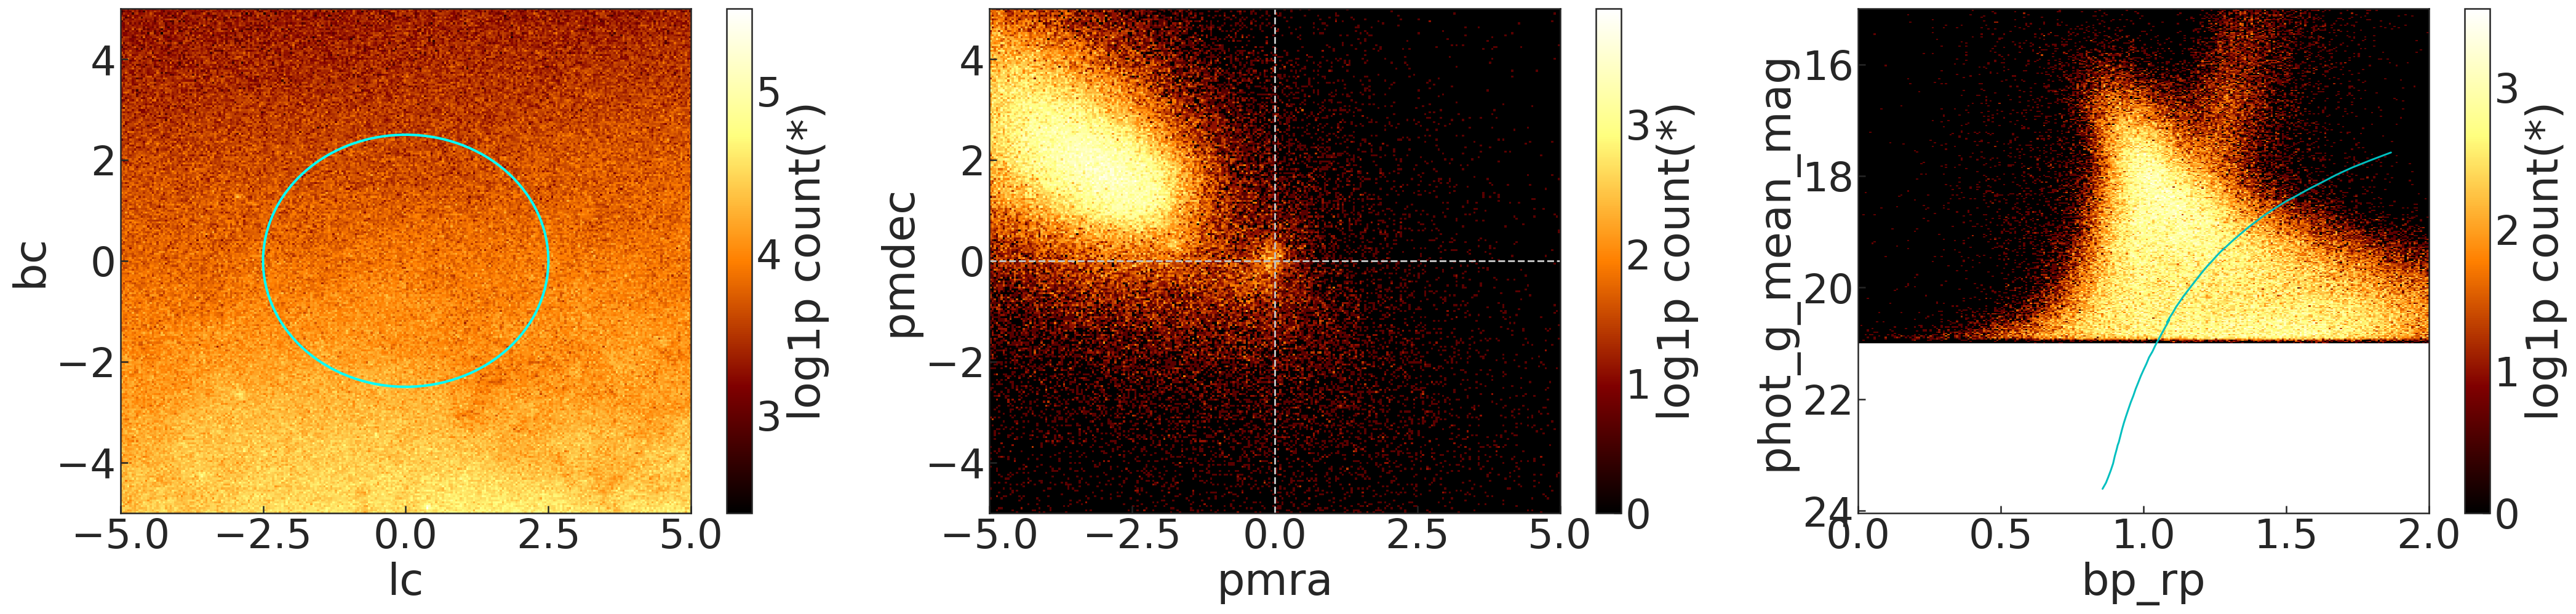

In [15]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection='ruwe<1.4')


circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
axes[0].add_patch(circ)




plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=base_selection)

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection)

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(130, iso_Gabs),c='c')

In [16]:
coarse_pm_selection = (df.pmra.abs()<0.5)&(df.pmdec.abs()<0.5)

(21.0, 15.0)

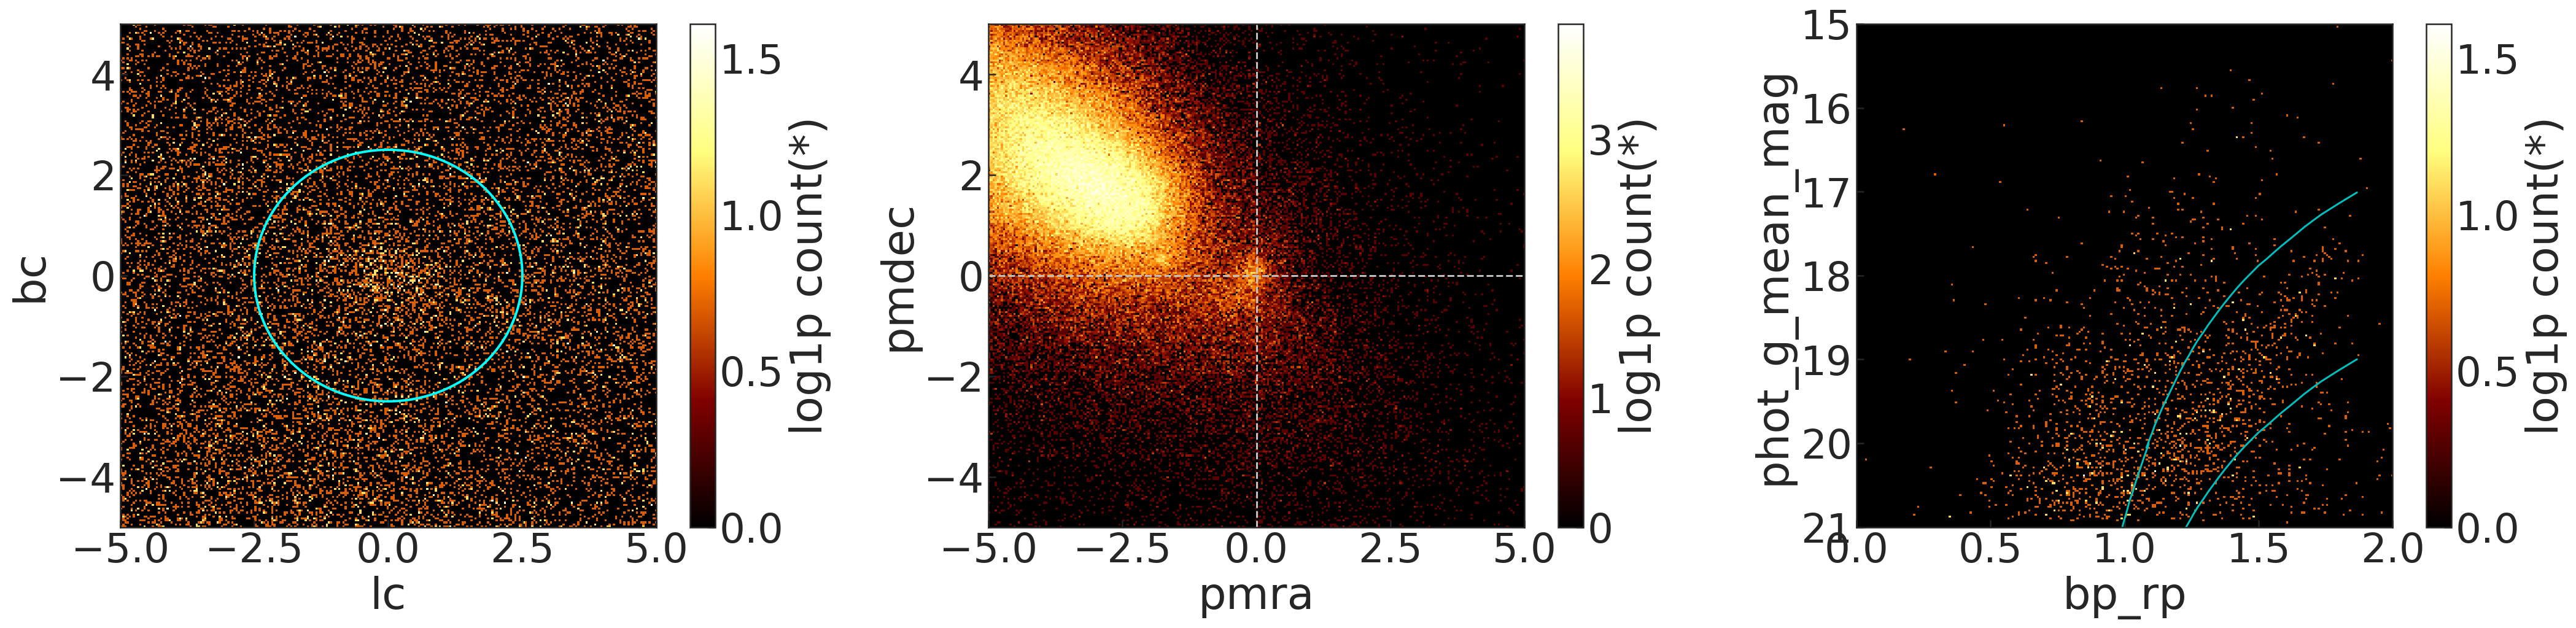

In [17]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4))


circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
axes[0].add_patch(circ)




plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=base_selection)

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection&coarse_pm_selection)

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

axes[2].set_ylim(21,15)

In [18]:
### Adding photometric mask
df['phot_mask'] = isochrone_mask(100,250 ,*df.evaluate(['bp_rp','phot_g_mean_mag']))

(21.0, 15.0)

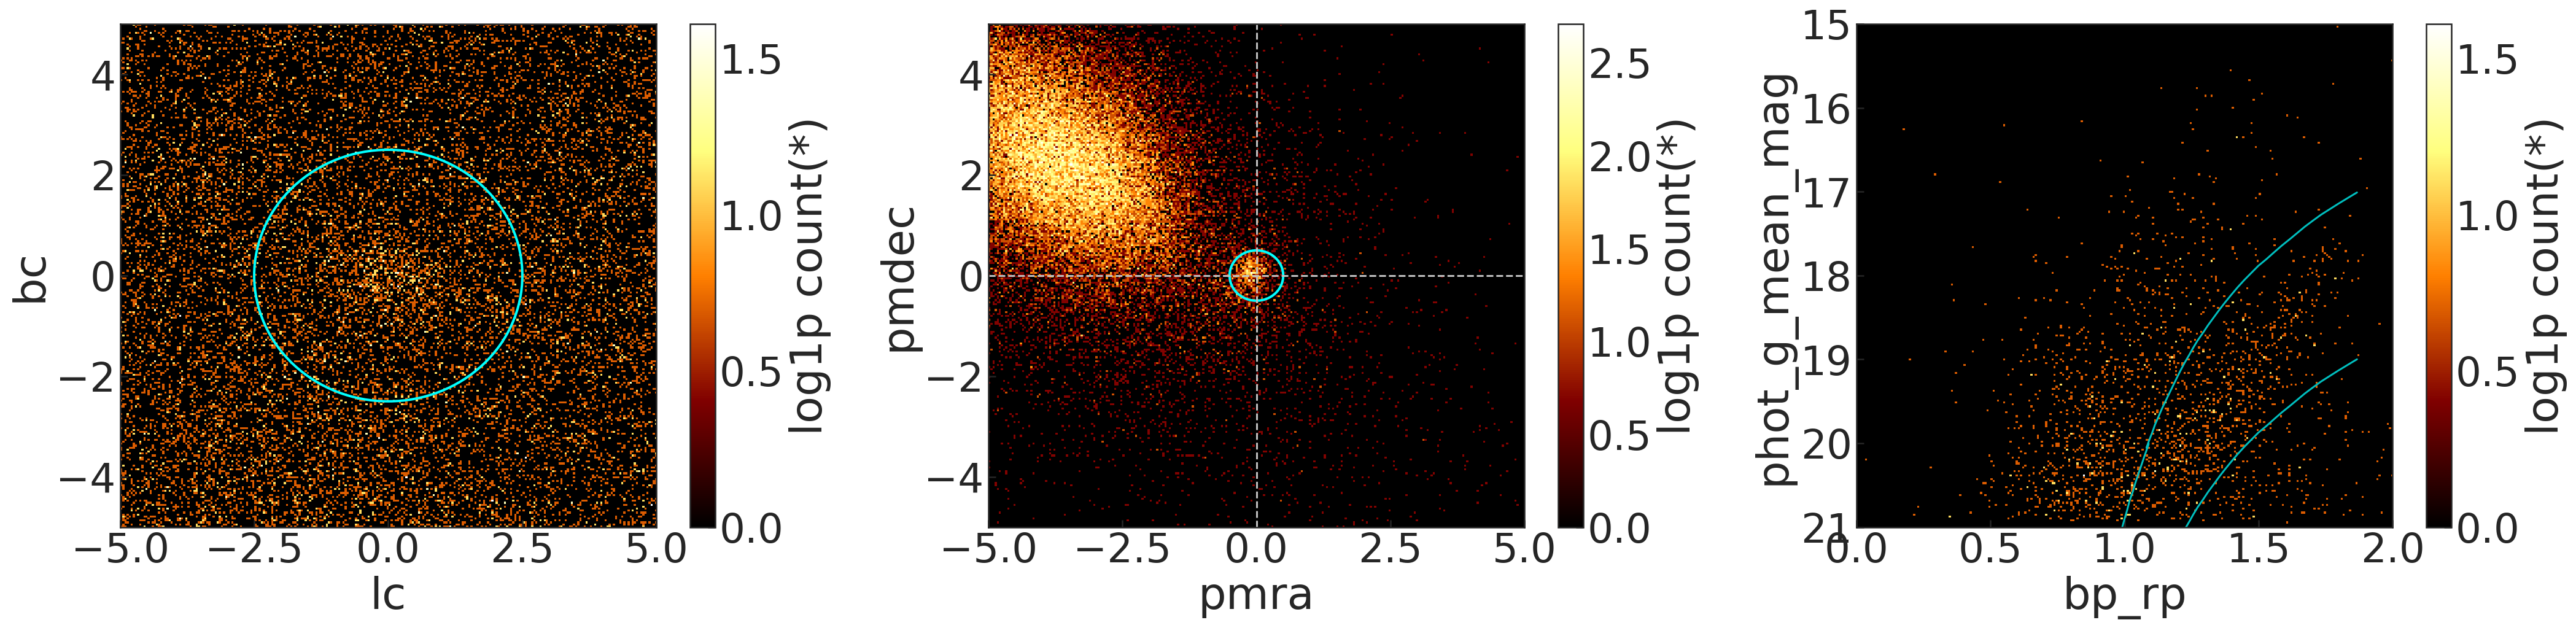

In [38]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4))


circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
axes[0].add_patch(circ)
circ = Circle([0,0],0.5 , ec='cyan', fc='none', lw=2)
axes[1].add_patch(circ)



plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask))




plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection&coarse_pm_selection)

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

axes[2].set_ylim(21,15)

In [20]:
df['mu'] = (df.pmra**2+df.pmdec**2).sqrt()
df['Hg'] = df.phot_g_mean_mag + 5 * (df.mu).log10() - 10

- $G_\mathrm{abs} = m_g - 5\log_{10}{(d)} - 10$
- $H_g = m_g+5\log_{10}(\mu)-10$
- $H_g = G_\mathrm{abs} + 5\log_{10}(\frac{v_\mathrm{tan}}{4.74 (km s^{-1})})$



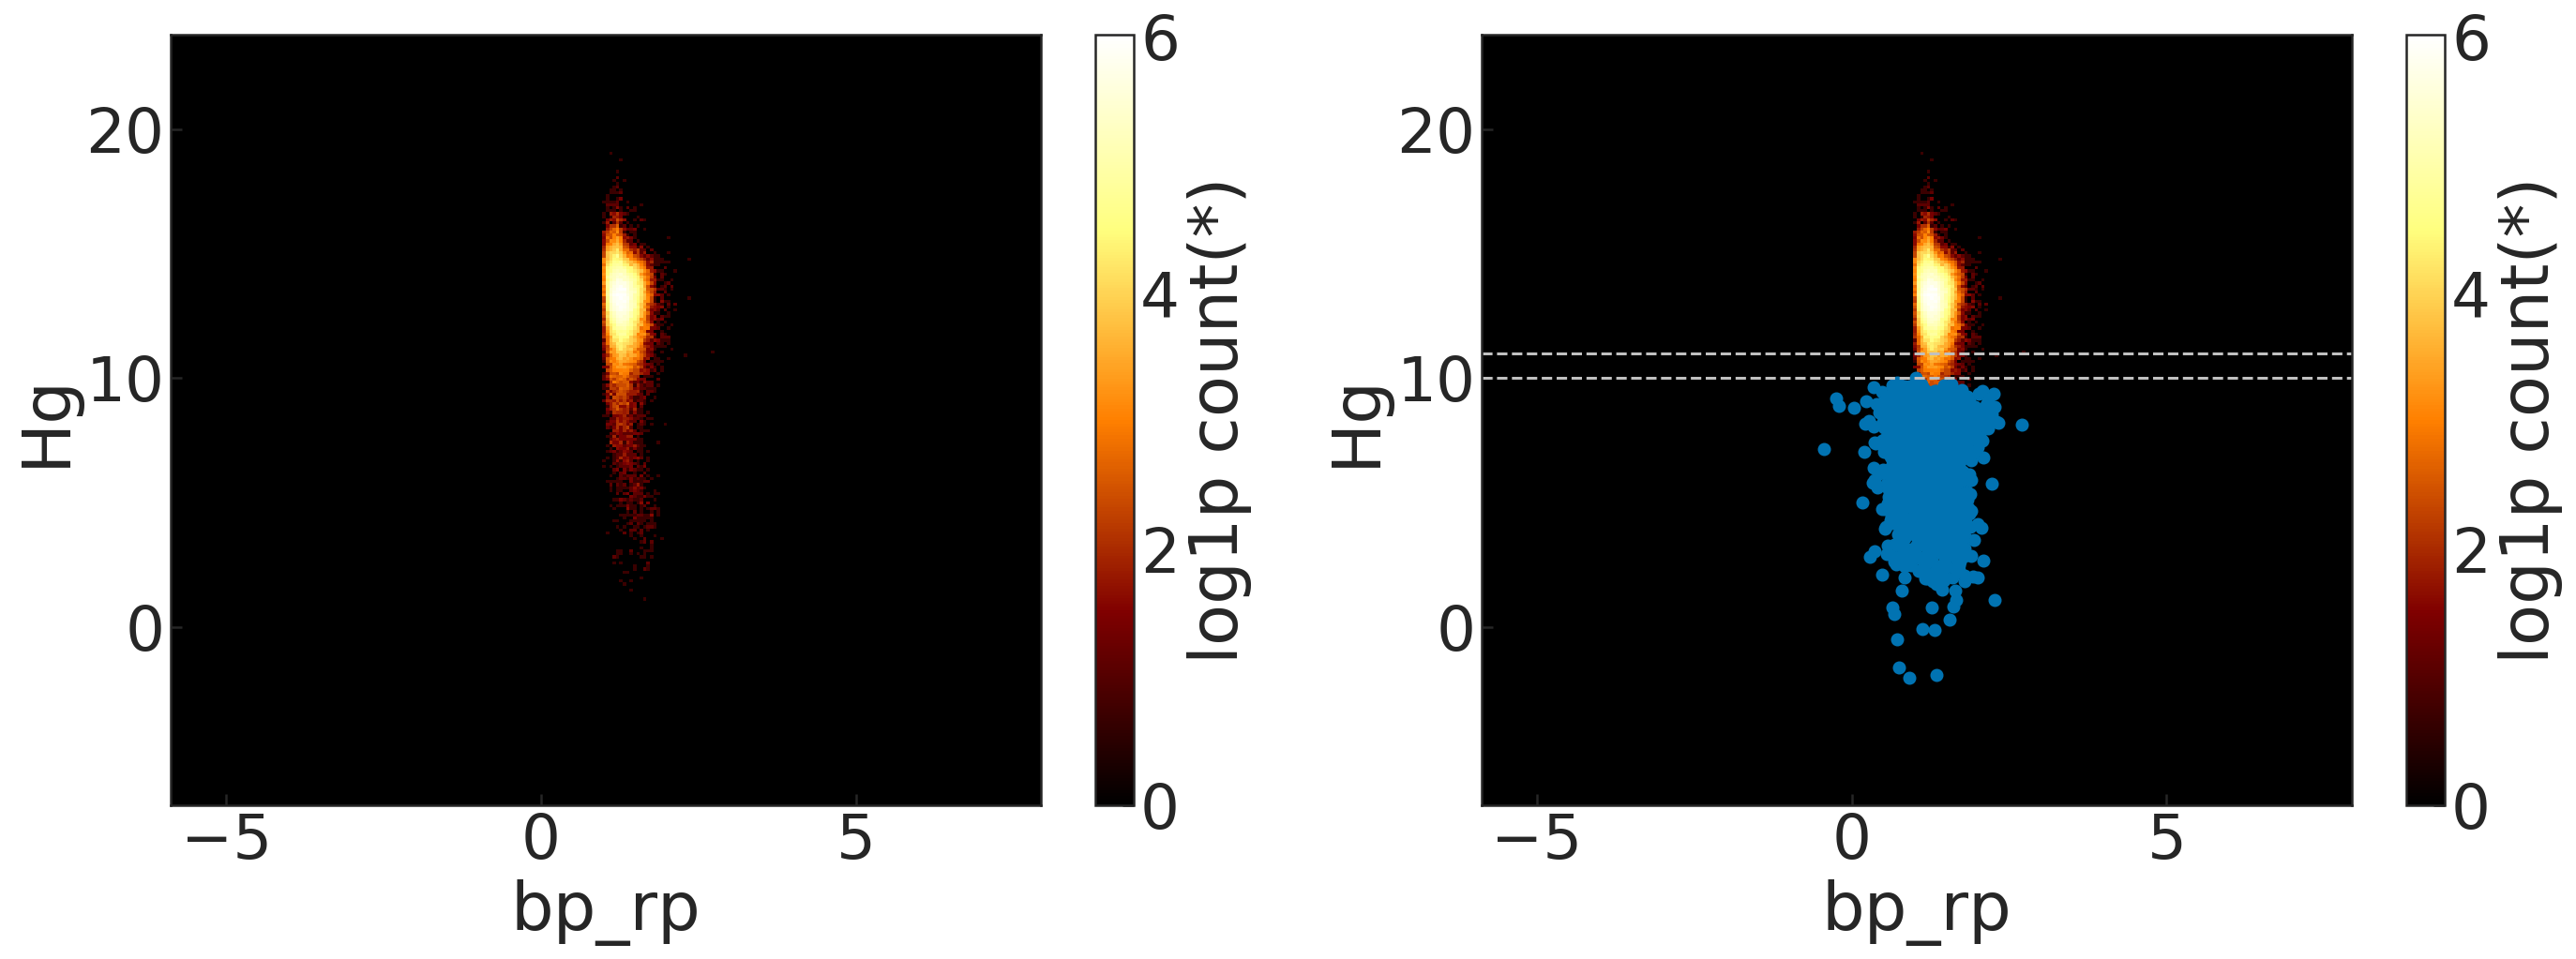

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))


plt.sca(axes[0])
df.plot('bp_rp','Hg', selection=(base_selection)&(df.phot_mask), f='log1p')


plt.sca(axes[1])
df.plot('bp_rp','Hg', selection=(base_selection)&(df.phot_mask), f='log1p')
df.scatter('bp_rp','Hg', selection=base_selection&coarse_pm_selection)
axes[1].axhline(10, ls='--',c='silver')
axes[1].axhline(11, ls='--',c='silver')

(21.0, 15.0)

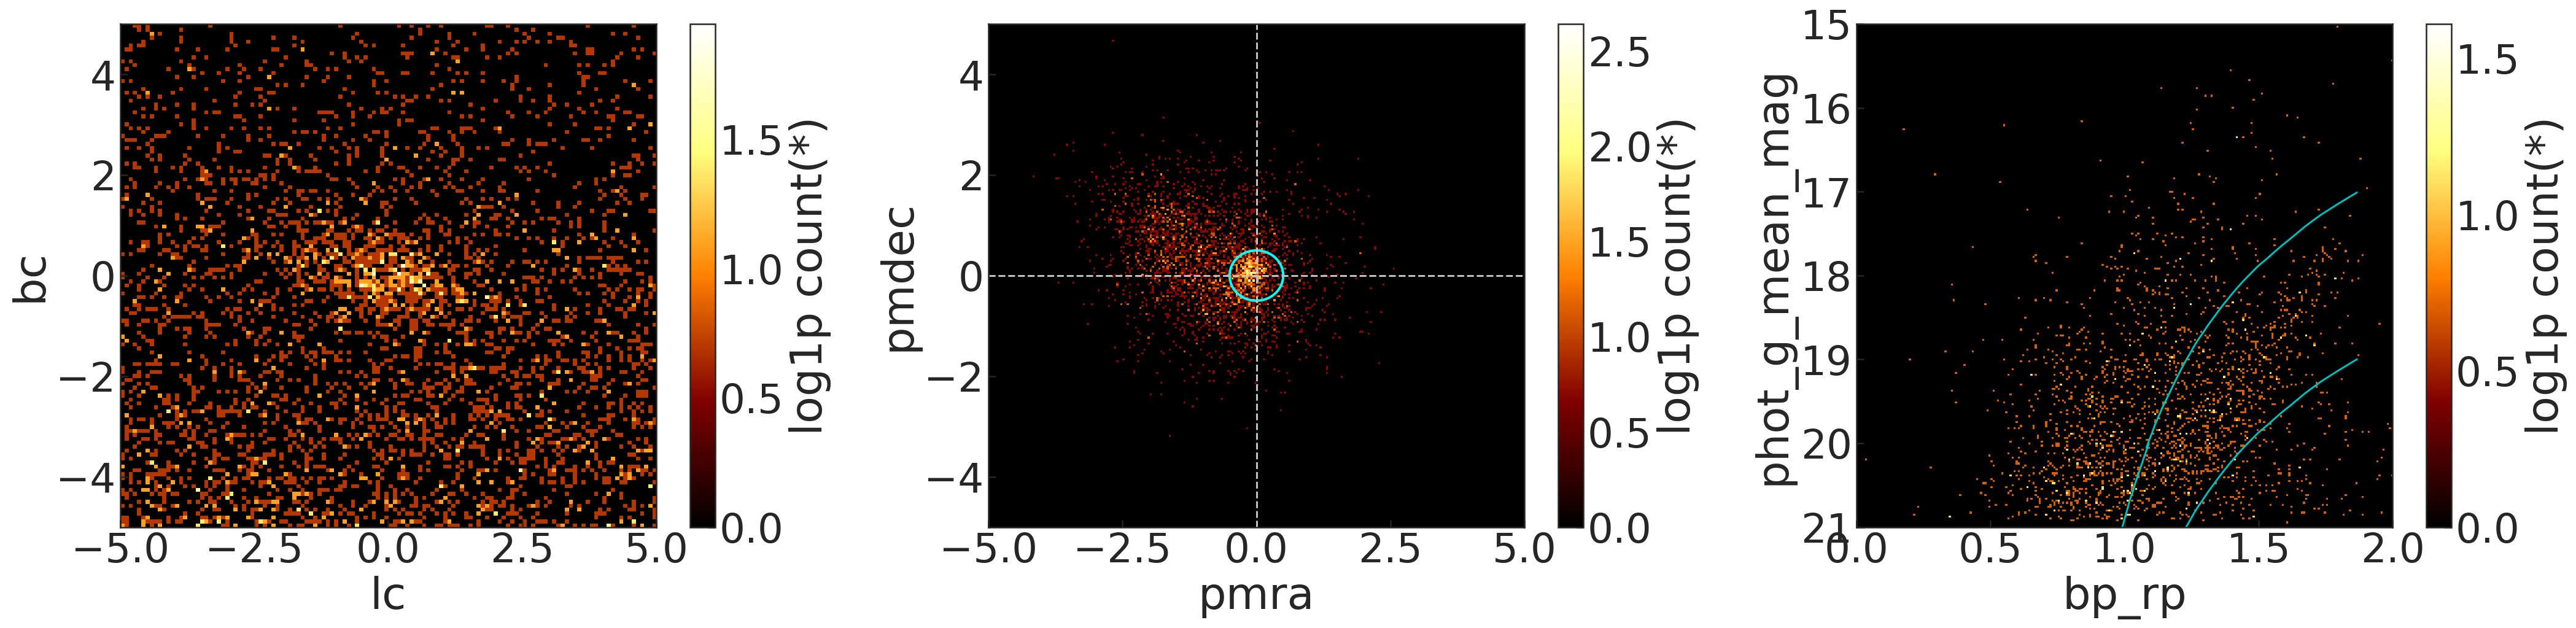

In [41]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4)&(df.Hg<11)&(df.phot_mask), shape=128)


# circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
# axes[0].add_patch(circ)


circ = Circle([0,0],0.5 , ec='cyan', fc='none', lw=2)
axes[1].add_patch(circ)


plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask)&(df.Hg<11))

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection&coarse_pm_selection&(df.Hg<11))

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

axes[2].set_ylim(21,15)

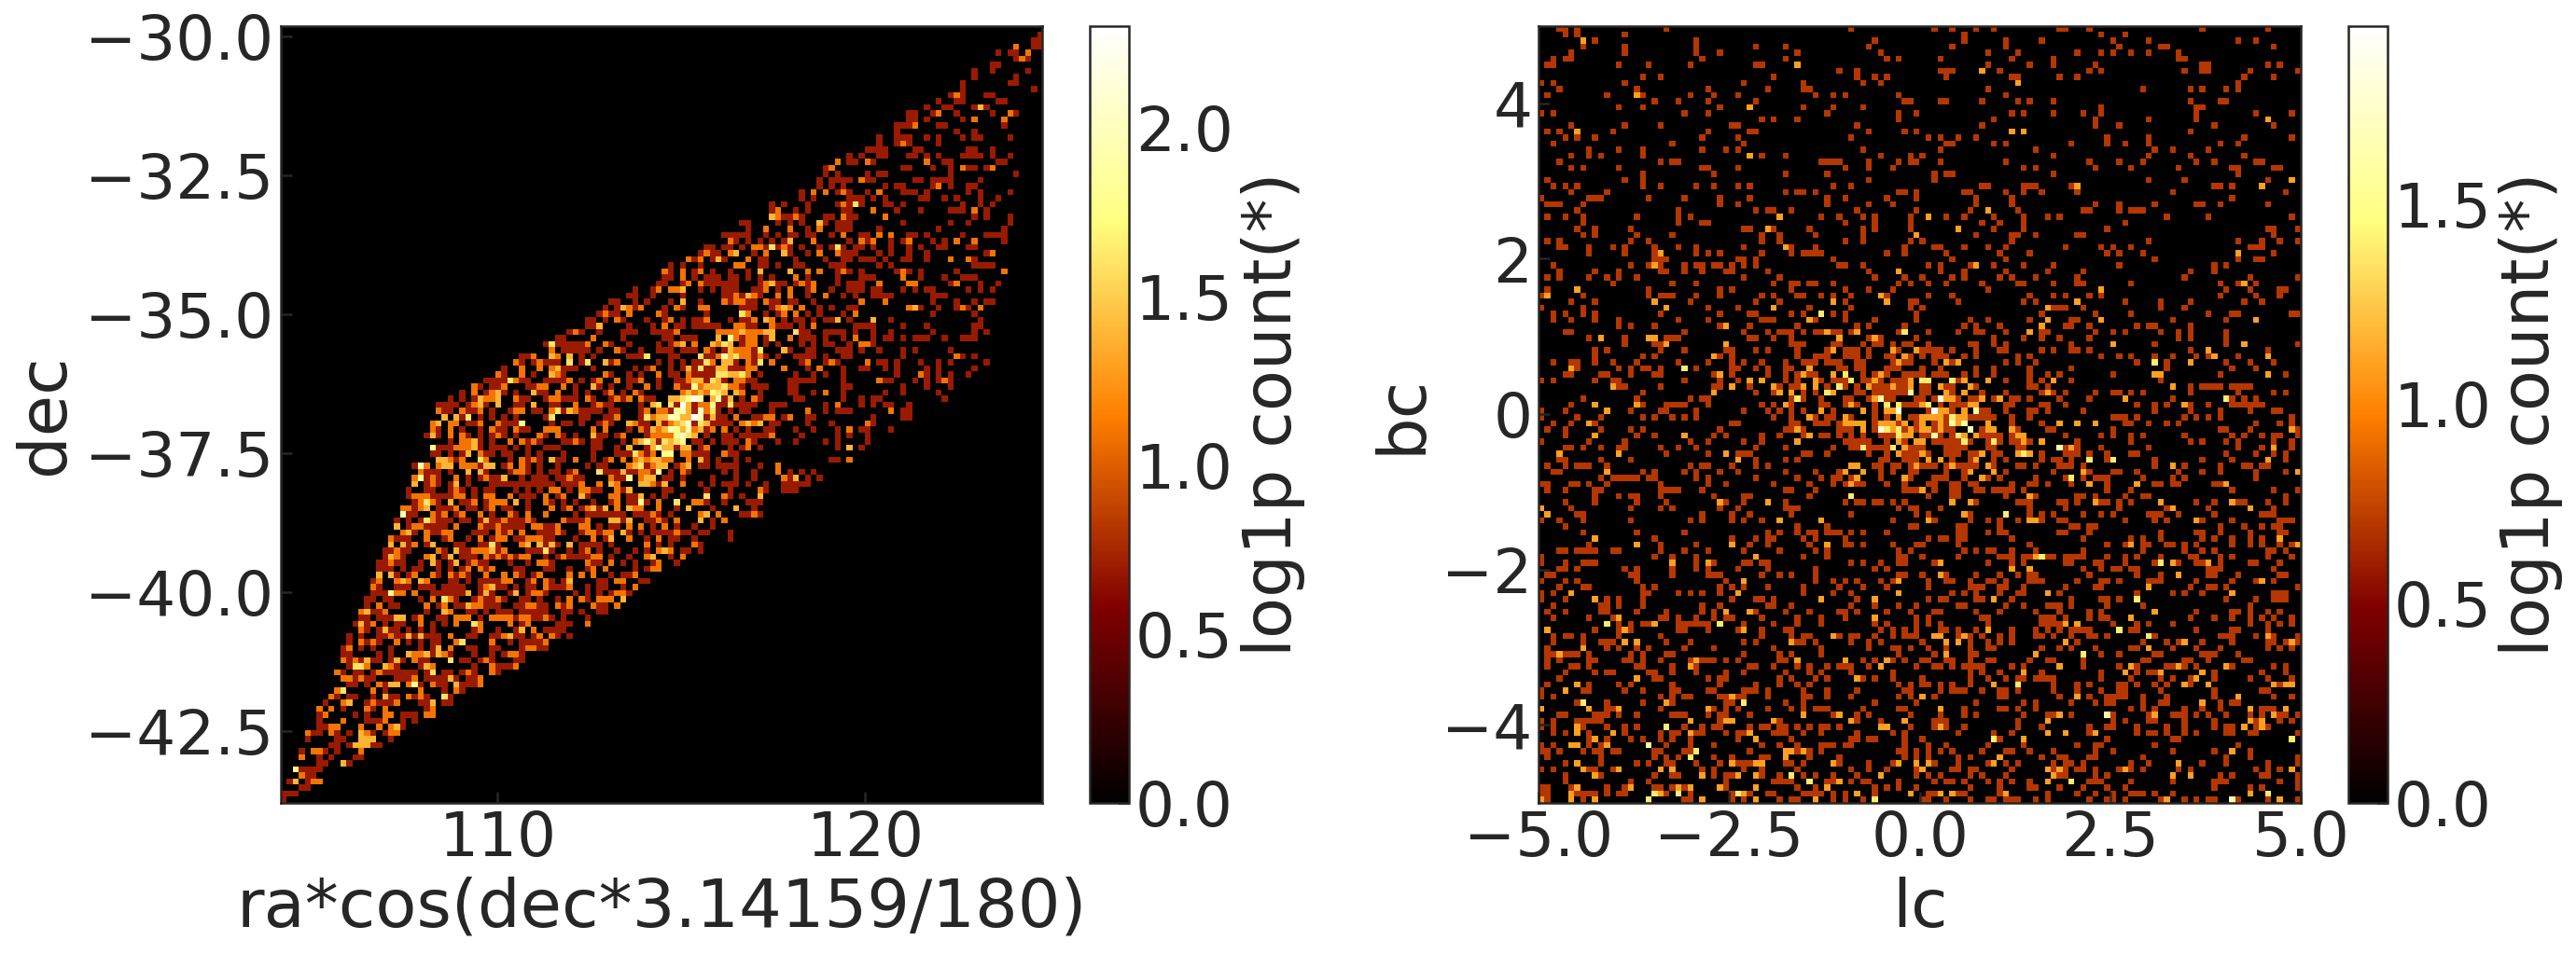

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))

plt.sca(axes[0])
df.plot('ra*cos(dec*3.14159/180)','dec', f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4)&(df.Hg<11)&(df.phot_mask), shape=128)


plt.sca(axes[1])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4)&(df.Hg<11)&(df.phot_mask), shape=128)



In [25]:
df.head(1)

#,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,lc,bc,angle,phot_mask,mu,Hg
0,1.63604e+18,Gaia EDR3 5413282187519246336,5.41328e+18,7.88244e+08,2016,145.81,0.303171,-42.4736,0.337912,0.501586,0.390468,1.28458,5.99782,-4.64961,0.394953,3.7888,0.392741,-0.114718,-0.0776118,-0.249358,0.24909,-0.00621014,0.231699,-0.501634,0.277554,0.0568793,0.00694948,392,0,391,1,-0.292399,400.156,0,0,31,False,1.41144,nan,nan,nan,nan,nan,nan,nan,45,26,0.593189,53,22,0,0.0111435,111.168,0,0,0.988634,0.273493,0.0551344,0.0673517,0.222477,-92.4623,-68.7609,4.98782,-12.8658,False,456,173.826,0.650334,267.288,20.0871,43,79.6389,4.92943,16.1558,20.5857,46,128.637,6.57136,19.5755,19.4745,0,1,0,0,0,1.19819,1.11125,0.498652,0.6126,nan,nan,0,nan,nan,nan,269.894,8.01165,169.627,-51.6654,4.99838,-3.23625,5.95236,True,5.99782,13.977


In [24]:
## Example with Extreme Deconvolution

In [25]:
from importlib import reload


In [26]:
import ExDec as XD

In [27]:
reload(XD)

<module 'ExDec' from '/data/koppelman/Research/Antlia2/ExDec.py'>

In [28]:
tmp_data, tmp_cov = XD.make_fake_data()

XD - fit
amp:  [0.33355548 0.33322226 0.33322226]
mean:  [[ 2.30624743 -4.38298507]
 [-7.43125258 -3.71473645]
 [ 9.93778157 -1.53636569]]
cov: [[[ 0.56237966 -0.01708008]
  [-0.01708008  0.52732649]]

 [[ 0.24641807 -0.01615504]
  [-0.01615504  0.28004848]]

 [[ 0.05305946  0.00725499]
  [ 0.00725499  0.05053928]]]


(array([0.33355548, 0.33322226, 0.33322226]),
 array([[ 2.30624743, -4.38298507],
        [-7.43125258, -3.71473645],
        [ 9.93778157, -1.53636569]]),
 array([[[ 0.56237966, -0.01708008],
         [-0.01708008,  0.52732649]],
 
        [[ 0.24641807, -0.01615504],
         [-0.01615504,  0.28004848]],
 
        [[ 0.05305946,  0.00725499],
         [ 0.00725499,  0.05053928]]]))

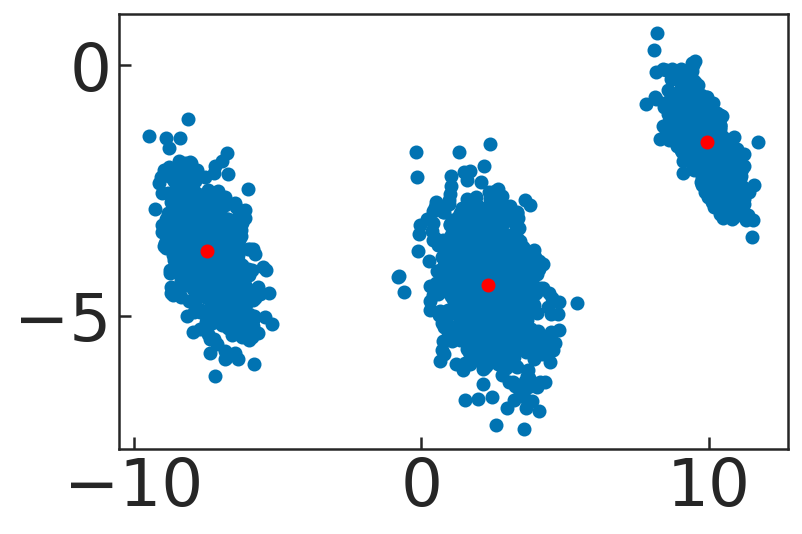

In [29]:
XD.XD_ND_Ncomp(tmp_data, tmp_cov)

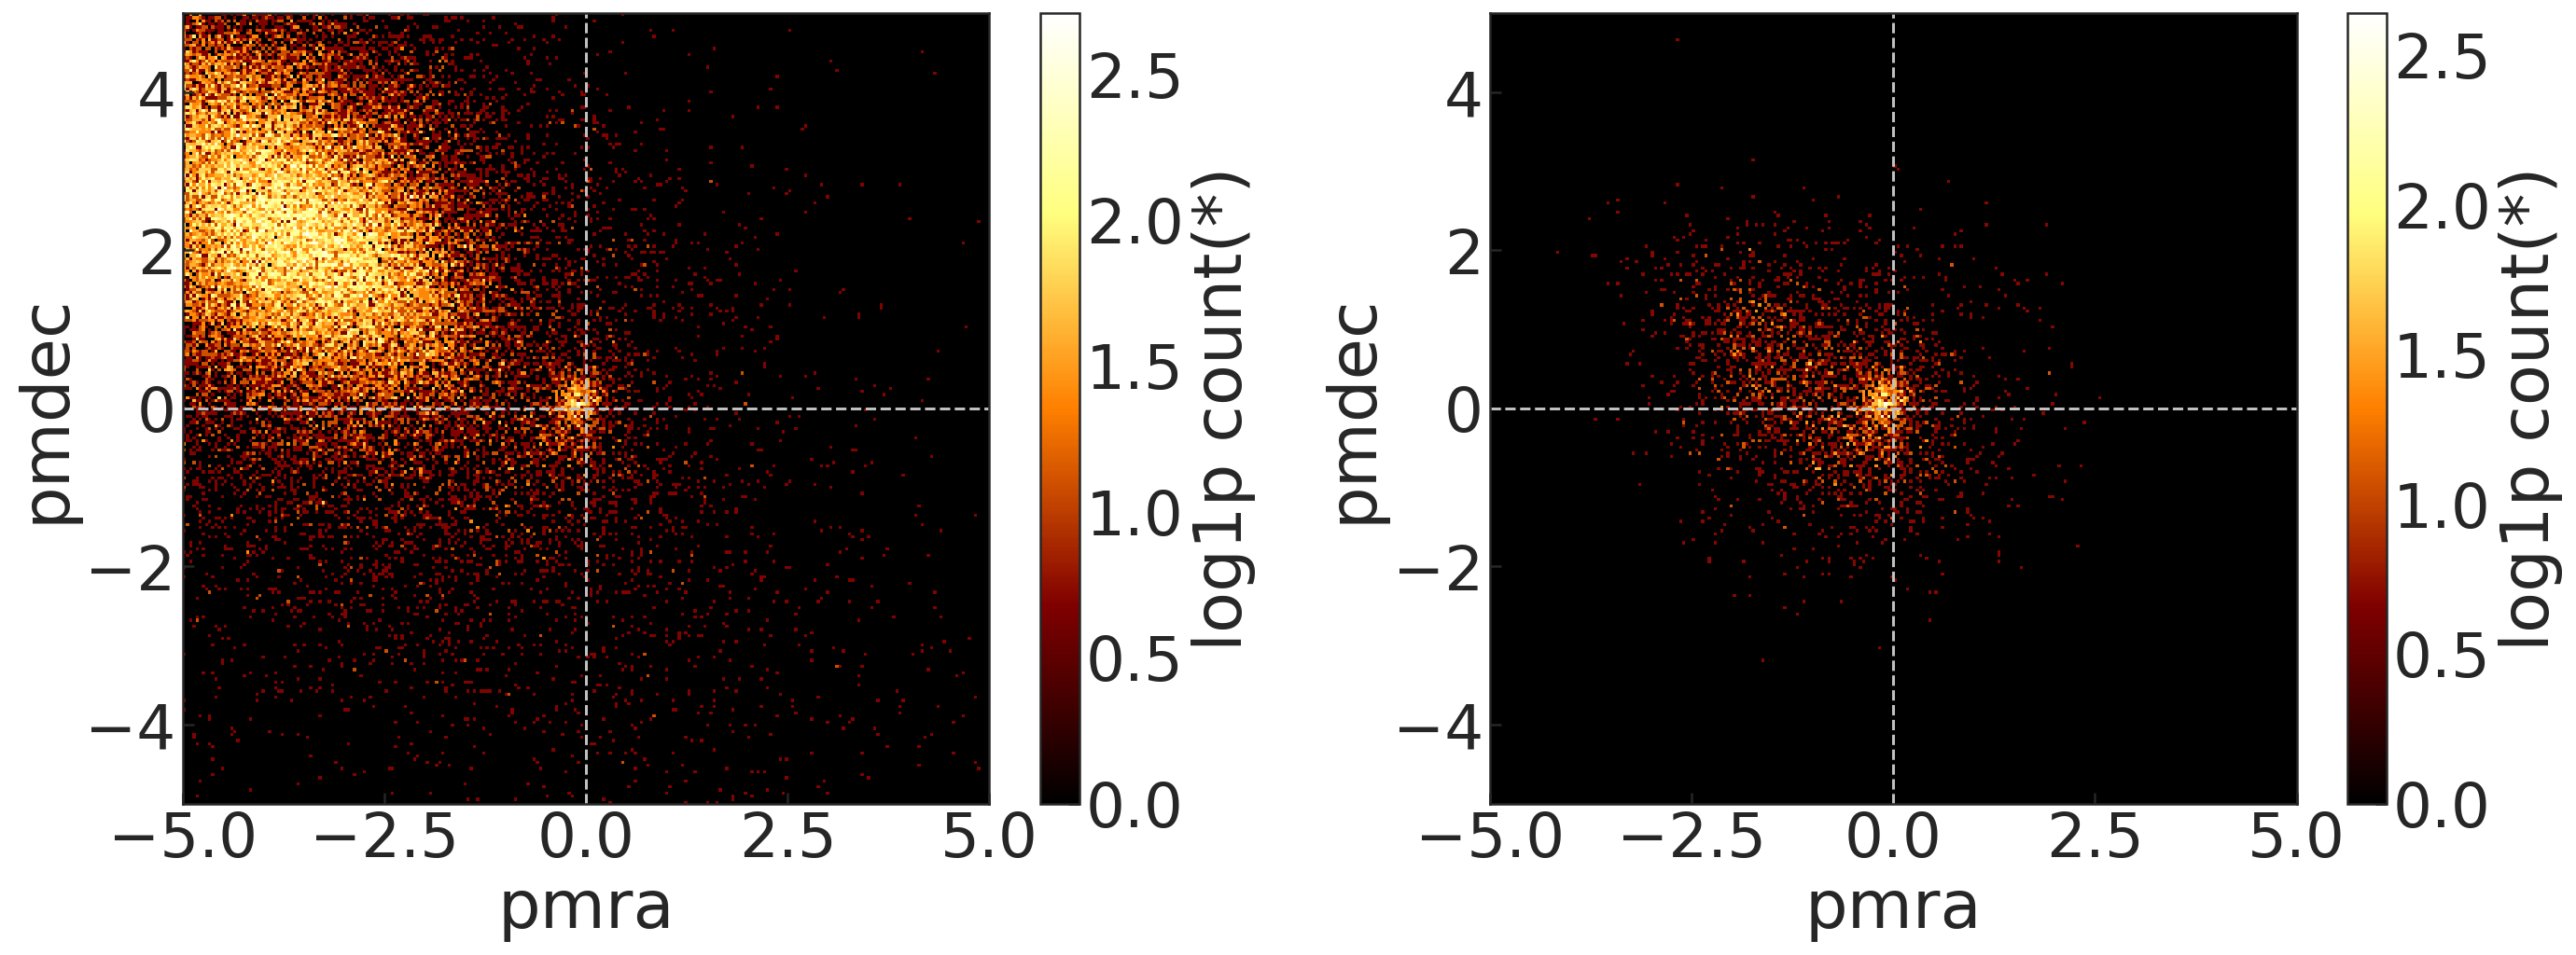

In [30]:
### Inferring Antlia 2's proper motion with XD

fig, axes = plt.subplots(ncols=2, figsize=(20,8))

plt.sca(axes[0])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask))

plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask)&(df.Hg<11))

for ax in axes:
    ax.axvline(0, ls='--', c='silver')
    ax.axhline(0, ls='--', c='silver')

In [31]:
df.count(selection = [(base_selection)&(df.phot_mask),
                      (base_selection)&(df.phot_mask)&(df.Hg<11)])

array([54112,  3331])

In [32]:
tmp_data.shape, tmp_cov.shape

((3001, 2), (3001, 2, 2))

In [33]:
data = np.array(df.evaluate(['pmra','pmdec'] ,
                             selection=(base_selection)&(df.phot_mask)&(df.Hg<11))).T

covar = np.array(df.evaluate(['pmra_error**2','pmra_error*pmdec_error*pmra_pmdec_corr',
                              'pmra_error*pmdec_error*pmra_pmdec_corr','pmdec_error**2'] ,
                             selection=(base_selection)&(df.phot_mask)&(df.Hg<11))).T.reshape(-1,2,2)

In [34]:
data.shape, covar.shape

((3331, 2), (3331, 2, 2))

In [49]:
XDamp, XDmean, XDcov = XD.XD_ND_Ncomp(data, covar, n_components=3, plot=False)

XD - fit
amp:  [0.35845913 0.39142427 0.2501166 ]
mean:  [[-0.60921323  0.17645365]
 [-1.29521627  0.39853988]
 [-0.10007413  0.0820521 ]]
cov: [[[ 1.19751368 -0.07190831]
  [-0.07190831  1.1818649 ]]

 [[ 0.62401955 -0.40501338]
  [-0.40501338  0.68432   ]]

 [[ 0.00212658  0.00145905]
  [ 0.00145905  0.00528214]]]


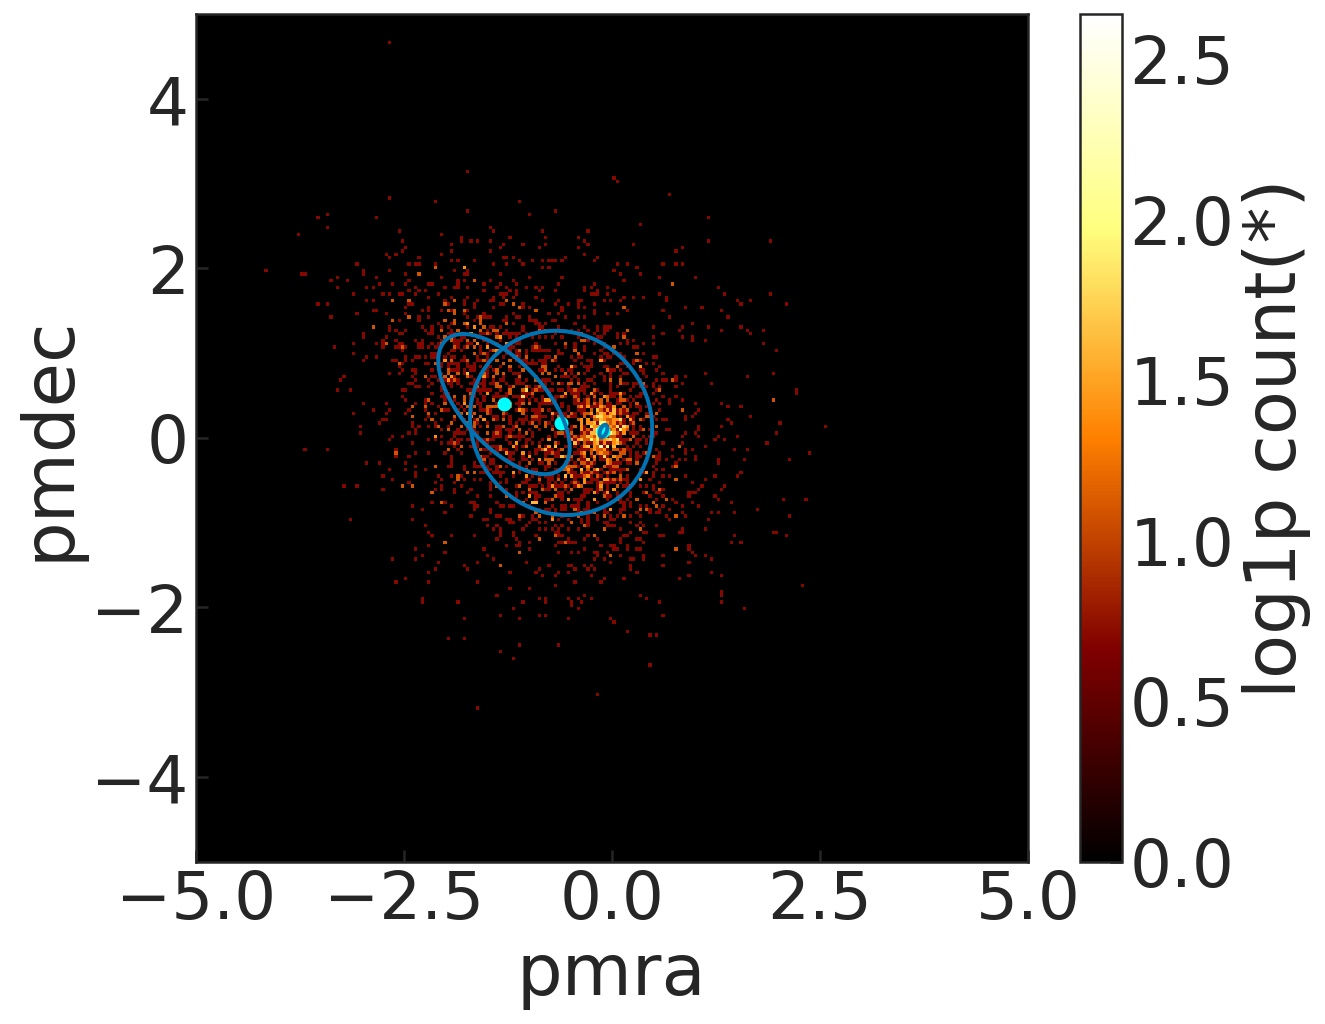

In [50]:
fig, ax = plt.subplots(figsize=(10,8))

df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask)&(df.Hg<11))

for _mean, _cov in zip(XDmean, XDcov):
    plt.scatter(*_mean, c='cyan', zorder=1)
    
    ell = XD.cov_ellipse(_mean, _cov, edgecolor='C0', lw=2, facecolor='none')
    ax.add_artist(ell)
    
plt.savefig('pm-plane-Antlia2.pdf',dpi=150, pad_inches=0.02,bbox_inches='tight')

In [51]:
for mean, cov in zip(XDmean, XDcov):
    fmt = 'pmra, pmdec = '
    for i, mi in enumerate(mean):
        fmt += f'({mi:.3f} +- {cov[i,i]**0.5:.3f}), '
    print(fmt[:-2])

pmra, pmdec = (-0.609 +- 1.094), (0.176 +- 1.087)
pmra, pmdec = (-1.295 +- 0.790), (0.399 +- 0.827)
pmra, pmdec = (-0.100 +- 0.046), (0.082 +- 0.073)


In [52]:
# # 3 components

# [[-0.60921323  0.17645365]
#  [-1.29521627  0.39853988]
#  [-0.10007413  0.0820521 ]]

In [53]:
 0.00212658**0.5,    0.00528214**0.5

(0.046114856608255865, 0.07267833239693933)

 From Chakrabarti et al. 2019:  
(ma cosd, md) = (-0.068, 0.032)  (0.023, -0.031) mas yr-1.

In [54]:
XDamp, XDmean, XDcov = XD.XD_ND_Ncomp(data, covar, n_components=4, plot=False)

XD - fit
amp:  [0.24329469 0.35515607 0.33023995 0.07130929]
mean:  [[-0.09912752  0.10022531]
 [-0.56631012  0.12329843]
 [-1.53112099  0.61949389]
 [-0.25424417 -0.4976784 ]]
cov: [[[ 1.86894421e-03  9.85592870e-04]
  [ 9.85592870e-04  1.98626123e-03]]

 [[ 1.17411511e+00 -6.79673549e-02]
  [-6.79673549e-02  1.20860416e+00]]

 [[ 4.40500246e-01 -2.14484527e-01]
  [-2.14484527e-01  5.56954637e-01]]

 [[ 1.20602220e-01 -2.99131305e-02]
  [-2.99131305e-02  2.59312610e-02]]]


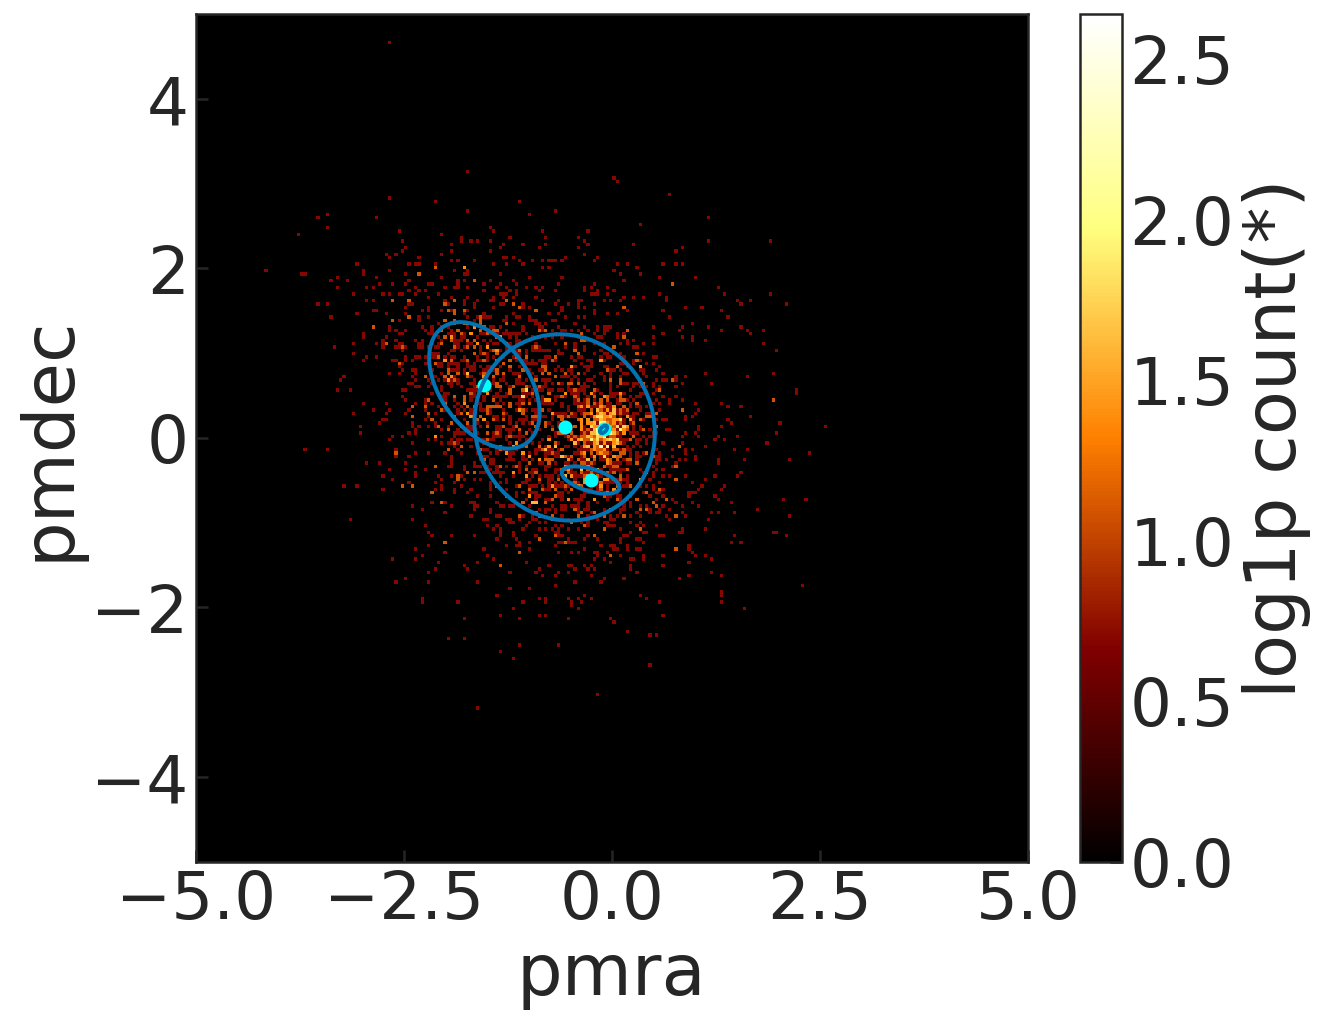

In [55]:
fig, ax = plt.subplots(figsize=(10,8))

df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask)&(df.Hg<11))

for _mean, _cov in zip(XDmean, XDcov):
    plt.scatter(*_mean, c='cyan', zorder=1)
    
    ell = XD.cov_ellipse(_mean, _cov, edgecolor='C0', lw=2, facecolor='none')
    ax.add_artist(ell)
    
plt.savefig('pm-plane-Antlia2-4comp.pdf',dpi=150, pad_inches=0.02,bbox_inches='tight')

In [56]:
for mean, cov in zip(XDmean, XDcov):
    fmt = 'pmra, pmdec = '
    for i, mi in enumerate(mean):
        fmt += f'({mi:.3f} +- {cov[i,i]**0.5:.3f}), '
    print(fmt[:-2])

pmra, pmdec = (-0.099 +- 0.043), (0.100 +- 0.045)
pmra, pmdec = (-0.566 +- 1.084), (0.123 +- 1.099)
pmra, pmdec = (-1.531 +- 0.664), (0.619 +- 0.746)
pmra, pmdec = (-0.254 +- 0.347), (-0.498 +- 0.161)


In [57]:
4-comp: pmra, pmdec = (-0.099 +- 0.043), (0.100 +- 0.045)
3-comp: pmra, pmdec = (-0.100 +- 0.046), (0.082 +- 0.073)

Chakrabarti+2019:
(ma cosd, md) = (-0.068, 0.032)  (0.023, -0.031) mas yr-1.